# FCDS-CNN Implementation for HAM10000 Skin Lesion Classification
## Architecture Overview (from Paper Table 7)

| Layer | Output Shape | Parameters |
|-------|--------------|------------|
| Conv2D(32, 3×3) | 222×222×32 | 896 |
| BatchNorm | 222×222×32 | 128 |
| MaxPool(2×2) | 111×111×32 | 0 |
| Conv2D(64, 3×3) | 109×109×64 | 18,496 |
| BatchNorm | 109×109×64 | 256 |
| MaxPool(2×2) | 54×54×64 | 0 |
| Dropout(0.25) | 54×54×64 | 0 |
| Conv2D(128, 3×3) | 52×52×128 | 73,856 |
| BatchNorm | 52×52×128 | 512 |
| MaxPool(2×2) | 26×26×128 | 0 |
| Dropout(0.25) | 26×26×128 | 0 |
| Flatten | 86,528 | 0 |
| Dense(256) | 256 | 22,151,424 |
| BatchNorm | 256 | 1,024 |
| Dropout(0.5) | 256 | 0 |
| Dense(7, softmax) | 7 | 1,799 |
| **Total** | | **22,248,391** |


## 1. Setup and Imports

In [55]:
from google.colab import drive
drive.mount('/content/drive')
print('Drive mounted successfully')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted successfully


In [56]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from collections import Counter
from sklearn.metrics import ( classification_report, confusion_matrix, roc_auc_score,precision_recall_fscore_support )

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Configuration

In [57]:
TFRECORD_DIR = '/content/drive/MyDrive/HAM10000/processed_tfrecords/tfrecords'
METADATA_DIR = '/content/drive/MyDrive/HAM10000/processed_tfrecords/metadata'
OUTPUT_DIR = '/content/drive/MyDrive/HAM10000/results_fcds_cnn_clean'
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 224
NUM_CLASSES = 7
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-3
SEED = 21

CONV1_FILTERS = 32
CONV2_FILTERS = 64
CONV3_FILTERS = 128
DENSE_UNITS = 256
DROPOUT_CONV = 0.25
DROPOUT_DENSE = 0.5

IDX_TO_LABEL = { 0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc' }
LABEL_TO_IDX = {v: k for k, v in IDX_TO_LABEL.items()}

PAPER_ACCURACY = 96.66
PAPER_PARAMS = 22248391

tf.random.set_seed(SEED)
np.random.seed(SEED)

print("=" * 60)
print("FCDS-CNN - Clean Implementation")
print("=" * 60)
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Expected params: ~{PAPER_PARAMS:,}")
print(f"Output directory: {OUTPUT_DIR}")

FCDS-CNN - Clean Implementation
Image size: 224x224
Batch size: 32
Epochs: 50
Learning rate: 0.001
Expected params: ~22,248,391
Output directory: /content/drive/MyDrive/HAM10000/results_fcds_cnn_clean


## 3. Data Loading

In [58]:
def get_tfrecord_files(tfrecord_dir, split):
    """Get sorted list of TFRecord files for a split."""

    pattern = os.path.join(tfrecord_dir, f'{split}-*.tfrecord')
    files = sorted(tf.io.gfile.glob(pattern))
    if len(files) == 0:
        raise FileNotFoundError(f"No {split} TFRecord files found in {tfrecord_dir}")
    return files


def parse_tfrecord(example_proto):
    """Parse a single TFRecord example."""

    feature_desc = {
        'image_id': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_bytes': tf.io.FixedLenFeature([], tf.string),
        'dx': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example_proto, feature_desc)


def count_class_distribution(files):
    """Count samples per class from TFRecord files."""

    dataset = tf.data.TFRecordDataset(files).map(parse_tfrecord)
    counts = Counter()
    for ex in dataset:
        counts[ex['label'].numpy()] += 1
    return dict(counts)


def compute_class_weights(train_dist, num_classes):
    """
    Compute class weights using inverse frequency.
    Formula: w_i = N / (K * n_i)
    """

    total_samples = sum(train_dist.values())
    weights = {
        k: total_samples / (num_classes * v)
        for k, v in train_dist.items()
    }
    return weights


print("Data loading functions defined")

Data loading functions defined


In [59]:
train_files = get_tfrecord_files(TFRECORD_DIR, 'train')
test_files = get_tfrecord_files(TFRECORD_DIR, 'test')

print(f"Train TFRecord files: {len(train_files)}")
print(f"Test TFRecord files: {len(test_files)}")

print("\nCounting samples (this may take a moment)...")
train_dist = count_class_distribution(train_files)
test_dist = count_class_distribution(test_files)

TRAIN_SAMPLES = sum(train_dist.values())
TEST_SAMPLES = sum(test_dist.values())

print(f"\nTotal train samples: {TRAIN_SAMPLES}")
print(f"Total test samples: {TEST_SAMPLES}")

print("\nTrain distribution:")
for idx in sorted(train_dist.keys()):
    pct = train_dist[idx] / TRAIN_SAMPLES * 100
    print(f"  {IDX_TO_LABEL[idx].upper()}: {train_dist[idx]:>4} ({pct:>5.1f}%)")

CLASS_WEIGHTS = compute_class_weights(train_dist, NUM_CLASSES)

print("\nClass weights (inverse frequency):")
for idx in sorted(CLASS_WEIGHTS.keys()):
    print(f"  {IDX_TO_LABEL[idx].upper()}: {CLASS_WEIGHTS[idx]:.3f}")

Train TFRecord files: 36
Test TFRecord files: 4

Counting samples (this may take a moment)...

Total train samples: 9013
Total test samples: 1002

Train distribution:
  AKIEC:  294 (  3.3%)
  BCC:  463 (  5.1%)
  BKL:  989 ( 11.0%)
  DF:  103 (  1.1%)
  MEL: 1002 ( 11.1%)
  NV: 6034 ( 66.9%)
  VASC:  128 (  1.4%)

Class weights (inverse frequency):
  AKIEC: 4.379
  BCC: 2.781
  BKL: 1.302
  DF: 12.501
  MEL: 1.285
  NV: 0.213
  VASC: 10.059


## 4. Data Augmentation

In [60]:
@tf.function
def augment_image(image, label):
    """
    Apply data augmentation:
    - Random horizontal and vertical flips
    - Random 90° rotations
    - Random zoom (0.85-1.0)
    - Random brightness/contrast/saturation
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    scale = tf.random.uniform([], 0.85, 1.0)
    new_size = tf.cast(tf.cast(IMG_SIZE, tf.float32) * scale, tf.int32)
    image = tf.image.resize(image, [new_size, new_size])
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE, IMG_SIZE)
    image = tf.image.random_brightness(image, 0.15)
    image = tf.image.random_contrast(image, 0.85, 1.15)
    image = tf.image.random_saturation(image, 0.85, 1.15)
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

print("Augmentation function defined")

Augmentation function defined


## 5. Dataset Creation

In [61]:
def create_train_dataset(files, batch_size):
    """Create training dataset with augmentation and shuffling."""

    def decode_example(example):
        image = tf.io.decode_jpeg(example['image_bytes'], channels=3)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = tf.cast(image, tf.float32) / 255.0
        return image, example['label']

    ds = tf.data.TFRecordDataset(files, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(decode_example, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.repeat()
    ds = ds.shuffle(4000, reshuffle_each_iteration=True)
    ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds


def create_test_dataset(files, batch_size):
    """Create test dataset without augmentation."""

    def decode_example(example):
        image = tf.io.decode_jpeg(example['image_bytes'], channels=3)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = tf.cast(image, tf.float32) / 255.0
        return image, example['label']

    ds = tf.data.TFRecordDataset(files, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(decode_example, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache()
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds


print("Creating datasets...")
train_ds = create_train_dataset(train_files, BATCH_SIZE)
test_ds = create_test_dataset(test_files, BATCH_SIZE)

STEPS_PER_EPOCH = TRAIN_SAMPLES // BATCH_SIZE
print(f"Steps per epoch: {STEPS_PER_EPOCH}")

print("\nVerifying dataset:")
for images, labels in train_ds.take(1):
    print(f"  Batch shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Image range: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")
    print(f"  Sample labels: {labels[:5].numpy()}")

Creating datasets...
Steps per epoch: 281

Verifying dataset:
  Batch shape: (32, 224, 224, 3)
  Labels shape: (32,)
  Image range: [0.000, 1.000]
  Sample labels: [5 5 5 5 0]


## 6. Model Architecture

In [62]:
def build_fcds_cnn(input_shape=(224, 224, 3), num_classes=7):
    """
    Architecture:
    - Conv2D(32, 3x3) -> BatchNorm -> MaxPool(2x2)
    - Conv2D(64, 3x3) -> BatchNorm -> MaxPool(2x2) -> Dropout(0.25)
    - Conv2D(128, 3x3) -> BatchNorm -> MaxPool(2x2) -> Dropout(0.25)
    - Flatten -> Dense(256) -> BatchNorm -> Dropout(0.5) -> Dense(7, softmax)

    Total parameters: 22,248,391

    IMPORTANT: Uses Conv2D, NOT SeparableConv2D!
    """

    inputs = tf.keras.Input(shape=input_shape, name='input_layer')

    # =========== BLOCK 1 ===========
    # Conv2D: 224x224x3 -> 222x222x32 (valid padding)
    # Params: 3*3*3*32 + 32 = 896
    x = tf.keras.layers.Conv2D(
        filters=CONV1_FILTERS,
        kernel_size=(3, 3),
        activation='relu',
        padding='valid',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )(inputs)

    # BatchNormalization: 4*32 = 128 params
    x = tf.keras.layers.BatchNormalization(name='batch_norm_1')(x)

    # MaxPooling: 222x222x32 -> 111x111x32
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='max_pool_1')(x)

    # =========== BLOCK 2 ===========
    # Conv2D: 111x111x32 -> 109x109x64
    # Params: 3*3*32*64 + 64 = 18,496
    x = tf.keras.layers.Conv2D(
        filters=CONV2_FILTERS,
        kernel_size=(3, 3),
        activation='relu',
        padding='valid',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(x)

    # BatchNormalization: 4*64 = 256 params
    x = tf.keras.layers.BatchNormalization(name='batch_norm_2')(x)

    # MaxPooling: 109x109x64 -> 54x54x64
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='max_pool_2')(x)

    # Dropout
    x = tf.keras.layers.Dropout(DROPOUT_CONV, name='dropout_1')(x)

    # =========== BLOCK 3 ===========
    # Conv2D: 54x54x64 -> 52x52x128
    # Params: 3*3*64*128 + 128 = 73,856
    x = tf.keras.layers.Conv2D(
        filters=CONV3_FILTERS,
        kernel_size=(3, 3),
        activation='relu',
        padding='valid',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(x)

    # BatchNormalization: 4*128 = 512 params
    x = tf.keras.layers.BatchNormalization(name='batch_norm_3')(x)

    # MaxPooling: 52x52x128 -> 26x26x128
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='max_pool_3')(x)

    # Dropout
    x = tf.keras.layers.Dropout(DROPOUT_CONV, name='dropout_2')(x)

    # =========== CLASSIFICATION HEAD ===========
    # Flatten: 26x26x128 = 86,528 units
    x = tf.keras.layers.Flatten(name='flatten')(x)

    # Dense: 86528 -> 256
    # Params: 86528*256 + 256 = 22,151,424
    x = tf.keras.layers.Dense(
        DENSE_UNITS,
        activation='relu',
        kernel_initializer='he_normal',
        name='dense_1'
    )(x)

    # BatchNormalization: 4*256 = 1,024 params
    x = tf.keras.layers.BatchNormalization(name='batch_norm_4')(x)

    # Dropout
    x = tf.keras.layers.Dropout(DROPOUT_DENSE, name='dropout_3')(x)

    # Output: 256 -> 7
    # Params: 256*7 + 7 = 1,799
    outputs = tf.keras.layers.Dense(
        num_classes,
        activation='softmax',
        name='output'
    )(x)

    model = tf.keras.Model(inputs, outputs, name='FCDS_CNN')

    return model


print("Model builder function defined")

Model builder function defined


In [63]:
model = build_fcds_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)

print("\n" + "=" * 70)
print("FCDS-CNN MODEL SUMMARY")
print("=" * 70)
model.summary()

print("\n" + "=" * 70)
print("PARAMETER VERIFICATION")
print("=" * 70)
total_params = model.count_params()

print(f"Our params:   {total_params:,}")
print(f"Paper params: {PAPER_PARAMS:,}")
print(f"Difference:   {abs(total_params - PAPER_PARAMS):,}")

if total_params == PAPER_PARAMS:
    print("✓ EXACT MATCH!")
elif abs(total_params - PAPER_PARAMS) < 1000:
    print("~ CLOSE MATCH (minor differences)")
else:
    print("✗ MISMATCH - Check architecture!")


FCDS-CNN MODEL SUMMARY


Model: "FCDS_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_1 (MaxPooling2D)       │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_2 (MaxPooling2D)       │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_3 (MaxPooling2D)       │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_4                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,248,391 (84.87 MB)

 Trainable params: 22,247,431 (84.87 MB)

 Non-trainable params: 960 (3.75 KB)


PARAMETER VERIFICATION
Our params:   22,248,391
Paper params: 22,248,391
Difference:   0
✓ EXACT MATCH!


## 7. Training

In [64]:

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'fcds_cnn_best.keras'),
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),

    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    ),
]

print("Callbacks defined:")
print("  - ModelCheckpoint (save best on val_accuracy)")
print("  - EarlyStopping (patience=15, monitor=val_accuracy)")
print("  - ReduceLROnPlateau (factor=0.5, patience=5)")

Callbacks defined:
  - ModelCheckpoint (save best on val_accuracy)
  - EarlyStopping (patience=15, monitor=val_accuracy)
  - ReduceLROnPlateau (factor=0.5, patience=5)


In [65]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled with:")
print(f"  - Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  - Loss: sparse_categorical_crossentropy")
print(f"  - Metrics: accuracy")
print(f"  - Class weights: Will be applied during training")

Model compiled with:
  - Optimizer: Adam (lr=0.001)
  - Loss: sparse_categorical_crossentropy
  - Metrics: accuracy
  - Class weights: Will be applied during training


In [66]:
print("\n" + "#" * 70)
print("# TRAINING FCDS-CNN")
print("#" * 70)
print(f"""
Configuration:
  - Epochs: {EPOCHS}
  - Steps per epoch: {STEPS_PER_EPOCH}
  - Batch size: {BATCH_SIZE}
  - Learning rate: {LEARNING_RATE}
  - Class weights: Applied
  - Total params: {model.count_params():,}
""")
print("Starting training...\n")

start_time = time.time()

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_ds,
    class_weight=CLASS_WEIGHTS,
    callbacks=callbacks,
    verbose=1
)

training_time = (time.time() - start_time) / 60
print(f"\nTraining completed in {training_time:.1f} minutes")


######################################################################
# TRAINING FCDS-CNN
######################################################################

Configuration:
  - Epochs: 50
  - Steps per epoch: 281
  - Batch size: 32
  - Learning rate: 0.001
  - Class weights: Applied
  - Total params: 22,248,391

Starting training...

Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2257 - loss: 2.5526
Epoch 1: val_accuracy improved from -inf to 0.05389, saving model to /content/drive/MyDrive/HAM10000/results_fcds_cnn_clean/fcds_cnn_best.keras


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


281/281 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.2258 - loss: 2.5515 - val_accuracy: 0.0539 - val_loss: 12.4783 - learning_rate: 0.0010
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3232 - loss: 1.8587
Epoch 2: val_accuracy improved from 0.05389 to 0.29541, saving model to /content/drive/MyDrive/HAM10000/results_fcds_cnn_clean/fcds_cnn_best.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.3233 - loss: 1.8585 - val_accuracy: 0.2954 - val_loss: 2.0329 - learning_rate: 0.0010
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3963 - loss: 1.6040
Epoch 3: val_accuracy improved from 0.29541 to 0.50000, saving model to /content/drive/MyDrive/HAM10000/results_fcds_cnn_clean/fcds_cnn_best.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.3963 - loss: 1.6039 - val_accuracy: 0.5000 - val_loss: 1.3619 - learning_rate: 0.0010
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4166 - loss: 1.5412
Epoch 4: val_ac

## 8. Evaluation

In [67]:
print("\n" + "=" * 60)
print("EVALUATION ON TEST SET")
print("=" * 60)

y_pred_proba = model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true[:len(y_pred)])

accuracy = np.mean(y_pred == y_true)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted'
)

try:
    auc_score = roc_auc_score(
        y_true, y_pred_proba, multi_class='ovr', average='weighted'
    )
except Exception as e:
    print(f"Warning: Could not compute AUC: {e}")
    auc_score = 0.0

print(f"\n{'Metric':<12} {'Ours':<10} {'Paper':<10} {'Diff':<10}")
print("-" * 45)
print(f"{'Accuracy':<12} {accuracy*100:<10.2f} {PAPER_ACCURACY:<10.2f} {(accuracy*100-PAPER_ACCURACY):+.2f}")
print(f"{'Precision':<12} {precision:<10.4f} {'0.96':<10} {precision-0.96:+.4f}")
print(f"{'Recall':<12} {recall:<10.4f} {'0.96':<10} {recall-0.96:+.4f}")
print(f"{'F1':<12} {f1:<10.4f} {'0.97':<10} {f1-0.97:+.4f}")
print(f"{'AUC':<12} {auc_score:<10.4f} {'0.96':<10} {auc_score-0.96:+.4f}")


EVALUATION ON TEST SET
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Metric       Ours       Paper      Diff      
---------------------------------------------
Accuracy     65.17      96.66      -31.49
Precision    0.7358     0.96       -0.2242
Recall       0.6517     0.96       -0.3083
F1           0.6798     0.97       -0.2902
AUC          0.8775     0.96       -0.0825


In [68]:
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)

target_names = [IDX_TO_LABEL[i].upper() for i in range(NUM_CLASSES)]
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)


CLASSIFICATION REPORT
              precision    recall  f1-score   support

       AKIEC       0.59      0.52      0.55        33
         BCC       0.34      0.71      0.46        51
         BKL       0.41      0.47      0.44       110
          DF       0.18      0.58      0.27        12
         MEL       0.32      0.32      0.32       111
          NV       0.91      0.73      0.81       671
        VASC       0.23      0.86      0.36        14

    accuracy                           0.65      1002
   macro avg       0.43      0.60      0.46      1002
weighted avg       0.74      0.65      0.68      1002



## 9. Visualizations

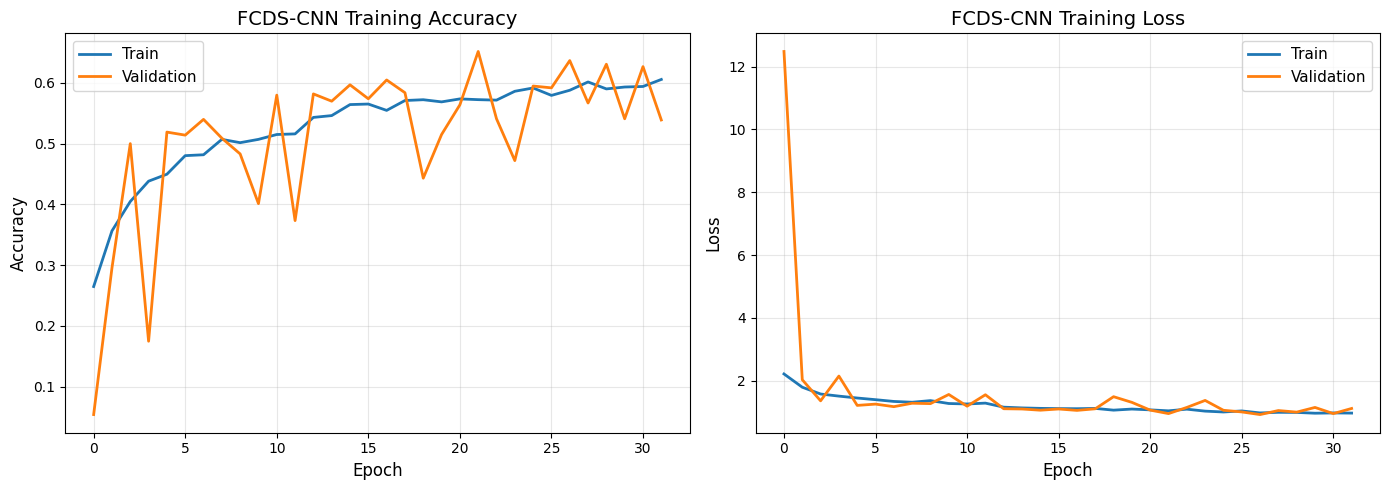

Training curves saved to /content/drive/MyDrive/HAM10000/results_fcds_cnn_clean


In [69]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('FCDS-CNN Training Accuracy', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('FCDS-CNN Training Loss', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    os.path.join(OUTPUT_DIR, 'fcds_cnn_training_history.png'),
    dpi=150,
    bbox_inches='tight'
)
plt.show()
print(f"Training curves saved to {OUTPUT_DIR}")

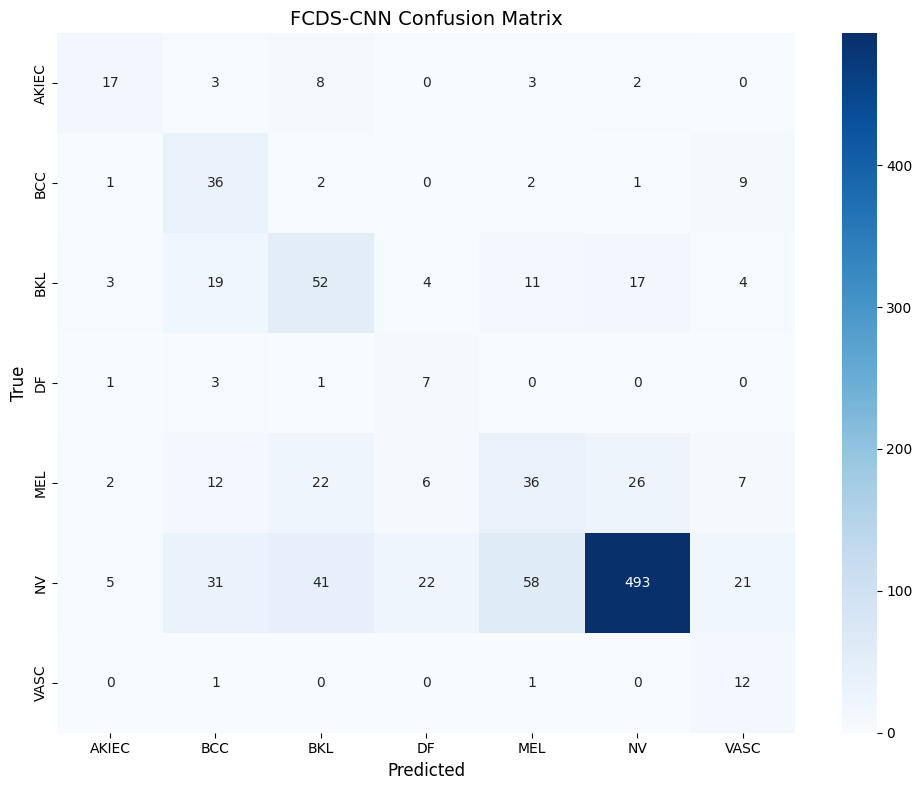

Confusion matrix saved to /content/drive/MyDrive/HAM10000/results_fcds_cnn_clean


In [70]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[IDX_TO_LABEL[i].upper() for i in range(NUM_CLASSES)],
    yticklabels=[IDX_TO_LABEL[i].upper() for i in range(NUM_CLASSES)]
)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('FCDS-CNN Confusion Matrix', fontsize=14)

plt.tight_layout()
plt.savefig(
    os.path.join(OUTPUT_DIR, 'fcds_cnn_confusion_matrix.png'),
    dpi=150,
    bbox_inches='tight'
)
plt.show()
print(f"Confusion matrix saved to {OUTPUT_DIR}")

## 10. Save Results

In [71]:
model.save(os.path.join(OUTPUT_DIR, 'fcds_cnn_final.keras'))

results_df = pd.DataFrame([{
    'Model': 'FCDS-CNN',
    'Accuracy': accuracy * 100,
    'Precision': precision,
    'Recall': recall,
    'F1': f1,
    'AUC': auc_score,
    'Paper_Accuracy': PAPER_ACCURACY,
    'Training_Time_Min': training_time,
    'Total_Params': model.count_params(),
    'Paper_Params': PAPER_PARAMS,
    'Epochs_Trained': len(history.history['accuracy']),
    'Learning_Rate': LEARNING_RATE,
    'Batch_Size': BATCH_SIZE
}])

results_df.to_csv(
    os.path.join(OUTPUT_DIR, 'fcds_cnn_results.csv'),
    index=False
)

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(
    os.path.join(OUTPUT_DIR, 'fcds_cnn_history.csv'),
    index=False
)

print(f"\nAll results saved to {OUTPUT_DIR}")
print("\nResults summary:")
print(results_df.T)


All results saved to /content/drive/MyDrive/HAM10000/results_fcds_cnn_clean

Results summary:
                           0
Model               FCDS-CNN
Accuracy           65.169661
Precision           0.735814
Recall              0.651697
F1                  0.679841
AUC                 0.877452
Paper_Accuracy         96.66
Training_Time_Min   8.706549
Total_Params        22248391
Paper_Params        22248391
Epochs_Trained            32
Learning_Rate          0.001
Batch_Size                32


In [72]:
print("\n" + "=" * 70)
print("FCDS-CNN TRAINING COMPLETE")
print("=" * 70)
print(f"""
RESULTS SUMMARY:
  Accuracy:     {accuracy*100:.2f}%
  Paper Target: {PAPER_ACCURACY}%
  Difference:   {accuracy*100 - PAPER_ACCURACY:+.2f}%

  Precision: {precision:.4f}
  Recall:    {recall:.4f}
  F1-Score:  {f1:.4f}
  AUC:       {auc_score:.4f}

TRAINING INFO:
  Training time: {training_time:.1f} minutes
  Epochs trained: {len(history.history['accuracy'])}
  Total parameters: {model.count_params():,}

FILES SAVED:
  - {OUTPUT_DIR}/fcds_cnn_final.keras
  - {OUTPUT_DIR}/fcds_cnn_best.keras
  - {OUTPUT_DIR}/fcds_cnn_results.csv
  - {OUTPUT_DIR}/fcds_cnn_history.csv
  - {OUTPUT_DIR}/fcds_cnn_training_history.png
  - {OUTPUT_DIR}/fcds_cnn_confusion_matrix.png
""")
print("=" * 70)


FCDS-CNN TRAINING COMPLETE

RESULTS SUMMARY:
  Accuracy:     65.17%
  Paper Target: 96.66%
  Difference:   -31.49%

  Precision: 0.7358
  Recall:    0.6517
  F1-Score:  0.6798
  AUC:       0.8775

TRAINING INFO:
  Training time: 8.7 minutes
  Epochs trained: 32
  Total parameters: 22,248,391

FILES SAVED:
  - /content/drive/MyDrive/HAM10000/results_fcds_cnn_clean/fcds_cnn_final.keras
  - /content/drive/MyDrive/HAM10000/results_fcds_cnn_clean/fcds_cnn_best.keras
  - /content/drive/MyDrive/HAM10000/results_fcds_cnn_clean/fcds_cnn_results.csv
  - /content/drive/MyDrive/HAM10000/results_fcds_cnn_clean/fcds_cnn_history.csv
  - /content/drive/MyDrive/HAM10000/results_fcds_cnn_clean/fcds_cnn_training_history.png
  - /content/drive/MyDrive/HAM10000/results_fcds_cnn_clean/fcds_cnn_confusion_matrix.png

